# AV Loan Prediction Problem - Data Preprocessing 

This is the iPython notebook wherein I preprocess the _train_ and _test_ datasets for the `Analytics Vidya Loan Prediction Problem` (@see: [Link on Analytics Vidya Website](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)). The analysis itself has been done in a separate notebook (@see [Analysis](AV Loan Prediction - Analysis & Prediction.ipynb)).

**Problem Statement: **
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. The company has to assess the eligibility for a loan of customers applying for a loan.

It wants to automate the loan eligibility process (real time) based on customer details provided while filling an online application form. These details are `Gender`, `Marital Status`, `Education`, `Number of Dependents`, `Income`,`Loan Amount`, `Credit History` etc. We have been provided a training dataset, whose layout is explained below.

Training dataset layout:
* **Loan_ID** -  Unique Loan ID
* **Gender**  -  Male/ Female
* **Married** -  Is applicant married? (Y/N)
* **Dependents** - Number of dependents
* **Education** - Applicant Education (Graduate/ Under Graduate)
* **Self_Employed** - Self employed (Y/N)
* **ApplicantIncome** - Applicant income
* **CoapplicantIncome** - Coapplicant income
* **LoanAmount** - Loan amount **in thousands**
* **Loan_Amount_Term** - Term of loan **in months**
* **Credit_History** - credit history meets guidelines
* **Property_Area** - Urban/ Semi Urban/ Rural
* **Loan_Status** - Loan approved (Y/N)

We have also been provided a test-set, with the same layout as above, except that the `Loan_Status` (or target) column is missing. 

### 1. Imports and Tweaks

In [42]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pprint

Pretty printing has been turned ON


In [43]:
# Numpy/Pandas & Seaborn tweaks
pd.set_option('display.notebook_repr_html',True)
pd.set_option('display.max_rows',25)
pd.set_option('display.max_columns',25)
pd.set_option('display.width',1024)
# force all Numpy & Pandas floating point output to 3 decimal places
float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)
# force Numpy to display very small floats using floating point notation
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=2048)
# force GLOBAL floating point output to 4 decimal places
%precision 4

# tweaks for Seaborn plotting library
plt.style.use('seaborn-muted')
sns.set_style('whitegrid')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
sns.set_context('talk')

seed = 42
np.random.seed(seed)

### 2. Data Loading and Preliminary Analysis

In [44]:
train_data_file, test_data_file = './data/loan_prediction_train_data.csv', './data/loan_prediction_test_data.csv'
train_df, test_df = pd.read_csv(train_data_file, index_col=0), pd.read_csv(test_data_file, index_col=0)

In [45]:
train_df.head()
#test_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0000,nan,360.0000,1.0000,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0000,128.0000,360.0000,1.0000,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0000,120.0000,360.0000,1.0000,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0000,141.0000,360.0000,1.0000,Urban,Y


Notice that the structures of both the data files are the same, except that the test set does not have the `Loan_Status` (target or predicted) field.

In [46]:
len(train_df), len(test_df)

(614, 367)

**Observations:**
* We have 614 training samples and 367 samples in the test set.
* Training data has 11 features. Emperically, we should have at least 100 records per feature, so we should have had at least 1100 records in the training set. Which means we either do not have sufficient records in the training set or we have redundant features!


In [47]:
# view information of the data fields
train_df.info()
#test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


**Observations:**
* Clearly there is missing data: For example - `Gender` has only 601 of 614 rows, `Dependents` has 599, `Self_Employed` has 582 and so on...
* We have a mix of categorical (`Gender, Married, Education, Self Employed and Property Area`) and numeric (`Incomes, LoanAmount, Loan_Amount_Term and Credit_History`) fields. `Credit_History` appears to be a Label encoded categorical (Yes|No) field, where 1 = Yes and 0 = No.

In [48]:
# and some statistical info for numeric fields
train_df.describe()
#test_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.0000,614.0000,592.0000,600.0000,564.0000
mean,5403.4593,1621.2458,146.4122,342.0000,0.8422
std,6109.0417,2926.2484,85.5873,65.1204,0.3649
min,150.0000,0.0000,9.0000,12.0000,0.0000
25%,2877.5000,0.0000,100.0000,360.0000,1.0000
50%,3812.5000,1188.5000,128.0000,360.0000,1.0000
75%,5795.0000,2297.2500,168.0000,360.0000,1.0000
max,81000.0000,41667.0000,700.0000,480.0000,1.0000


In [49]:
# description of categorical values
train_df.describe(include='O')

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422


In [50]:
train_df.isnull().sum()  # how many Nan's?

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Let's view the distributions of the numerical fields above, except for Credit History, which is actually a categorical field.

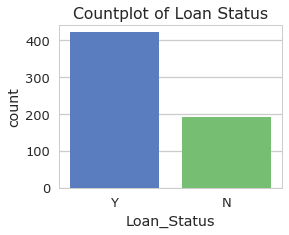

In [51]:
# distribution of the prediction col
f, ax = plt.subplots(figsize=(4,3))
sns.countplot(x='Loan_Status',data=train_df,ax=ax)
plt.title('Countplot of Loan Status')
plt.show()
plt.close()

We have twice as many `Y` rows as there are `N` rows. We may have to up-sampling of 'N' records or choose ROC-AUC as the performance metric.

In [52]:
for df in [train_df, test_df]:
    # create a new column TotalIncome to hold ApplicantIncome & Co-ApplicantIncome
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

/home/mjbhobe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


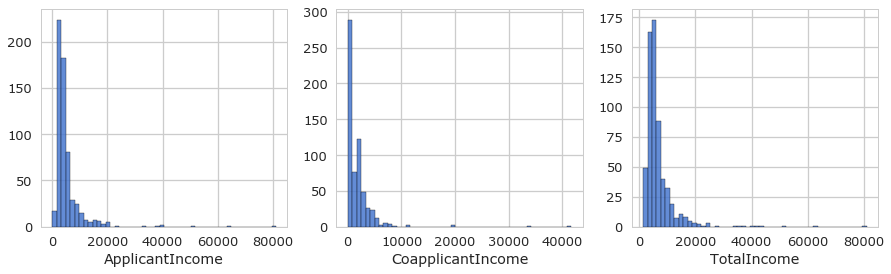

In [53]:
#train_df.hist(column='ApplicantIncome',bins=50)
columns = ['ApplicantIncome', 'CoapplicantIncome','TotalIncome']
f, ax = plt.subplots(nrows=1, ncols=len(columns), sharey=False, figsize=(15,4))
for i, col in enumerate(columns):
    _ = sns.distplot(train_df[col], bins=50, kde=False, rug=False, 
                     hist_kws={'edgecolor':'k','alpha':0.85}, ax=ax[i])

Notice that the incomes are right skewed (i.e the mean is >> than median) - this is typical of "Income" distribution plots.

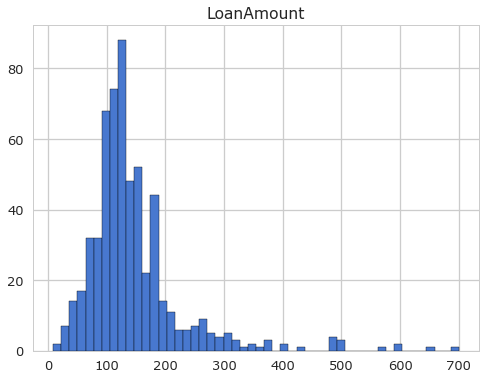

In [54]:
# can't use sns.distplot on LoanAmount due to NaN values
_ = train_df.hist(column='LoanAmount',bins=50, edgecolor='k',figsize=(8,6))

From the plots above, it is clear that we have a lot of outliers. Boxplots will confirm the same.

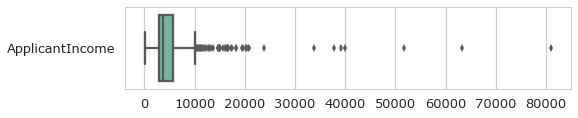

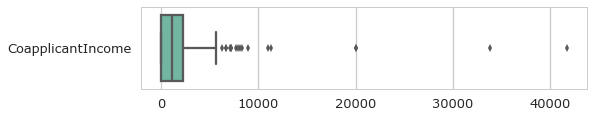

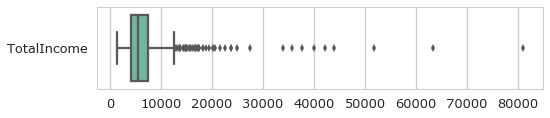

In [55]:
# zoom-in box plot of the key statistic of each feature
for row, col in enumerate(columns):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,1.5))
    sns.boxplot(data=train_df[[col]], orient='h', palette='Set2',ax=ax)
plt.show()
plt.close()

We can use a `log()` transformation to correct the skew-ness in the income data, as shown below. We will add additional columns `ApplicantIncome_Log`, `CoapplicantIncome_Log` and `TotalIncome_Log` to the datasets.

In [56]:
for col_name in columns:
    log_col_name = '%s_Log' % col_name
    
    # create a new col & assign 0.0 as default value
    train_df[log_col_name] = 0.0
    # set as log(col_name) for all rows where col_name != 0.0
    train_df.loc[train_df[col_name] != 0.0, [log_col_name]] = \
      np.log(train_df.loc[train_df[col_name] != 0.0, col_name])
    
    test_df[log_col_name] = 0.0
    test_df.loc[test_df[col_name] != 0.0, [log_col_name]] = \
      np.log(test_df.loc[test_df[col_name] != 0.0, col_name])

In [57]:
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log
Loan_ID,,,,,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0000,nan,360.0000,1.0000,Urban,Y,5849.0000,8.6740,0.0000,8.6740
LP001003,Male,Yes,1,Graduate,No,4583,1508.0000,128.0000,360.0000,1.0000,Rural,N,6091.0000,8.4301,7.3185,8.7146
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,Y,3000.0000,8.0064,0.0000,8.0064
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0000,120.0000,360.0000,1.0000,Urban,Y,4941.0000,7.8567,7.7656,8.5053
LP001008,Male,No,0,Graduate,No,6000,0.0000,141.0000,360.0000,1.0000,Urban,Y,6000.0000,8.6995,0.0000,8.6995


/home/mjbhobe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


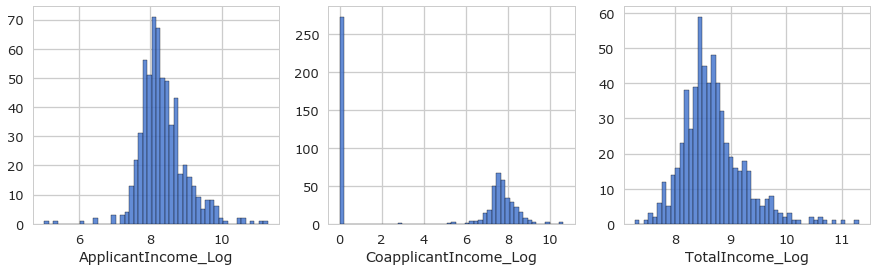

In [58]:
columns = ['ApplicantIncome_Log', 'CoapplicantIncome_Log','TotalIncome_Log']
f, ax = plt.subplots(nrows=1, ncols=len(columns), sharey=False, figsize=(15,4))
for i, col in enumerate(columns):
    _ = sns.distplot(train_df[col], bins=50, kde=False, rug=False, hist_kws={'edgecolor':'k','alpha':0.85}, ax=ax[i])

Now that is much better - the `log()` distribution appears to be more normally distributed. Notice that there is a huge bar at zero in the `CoapplicantIncome` field, which indicates that there are several customers with 0 Coapplicant incomes. Hence it would be better to use log(ApplicantIncome + CoapplicantIncome), which is what we have in `TotalIncome_Log` field.

The `TotalIncome_Log` field alone should suffice for our prediction model.

Let's do a quick check on the categorical fields, and their impact on the final outcome (i.e. `Loan_Status` field). We will create pivot tables on each of the categorical fields and compute the mean() of the `Loan_Status` decision, where `Y` ~= 1 and `N` ~= 0 [~= stands for 'is interpreted as']

In [59]:
# by credit history
cr_hist1 = train_df.pivot_table(values='Loan_Status',index=['Credit_History'],
                                aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# by gender
cr_hist2 = train_df.pivot_table(values='Loan_Status',index=['Gender'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# by Marital status
cr_hist3 = train_df.pivot_table(values='Loan_Status',index=['Married'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

# by dependents count
cr_hist4 = train_df.pivot_table(values='Loan_Status',index=['Dependents'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# by education
cr_hist5 = train_df.pivot_table(values='Loan_Status',index=['Education'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# by Self Employed status
cr_hist6 = train_df.pivot_table(values='Loan_Status',index=['Self_Employed'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# by property area
cr_hist7 = train_df.pivot_table(values='Loan_Status',index=['Property_Area'],
                                   aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

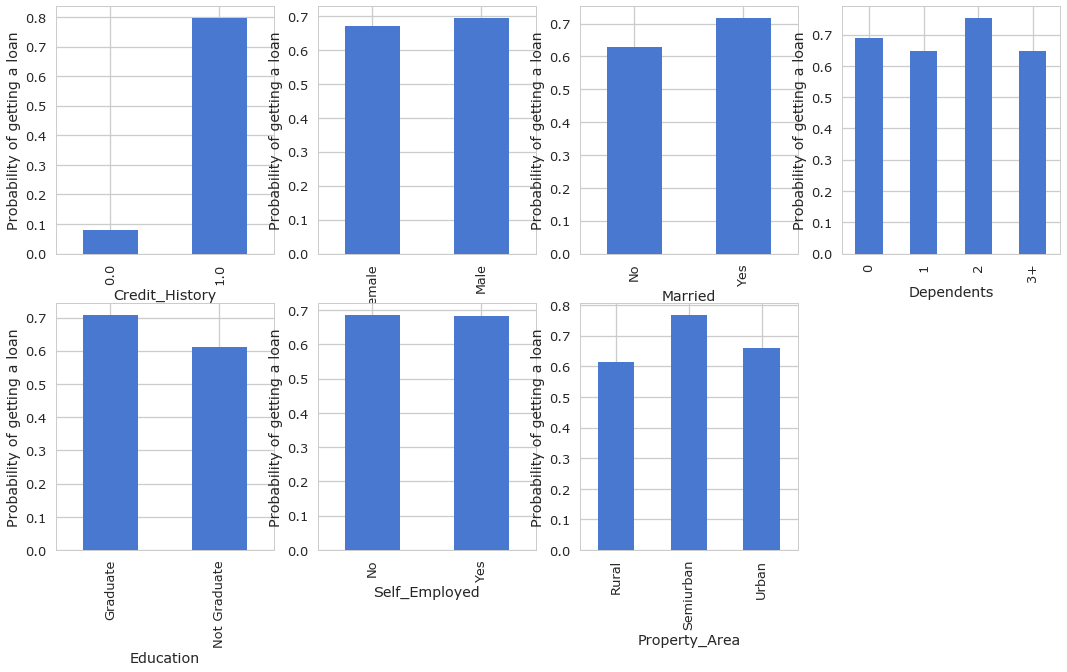

In [60]:
# lets plot each dataset above
fig  = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(241)
ax1.set_xlabel('Credit History')
ax1.set_ylabel('Probability of getting a loan')
cr_hist1.plot(kind='bar',ax=ax1,legend=False)

ax2 = fig.add_subplot(242)
ax2.set_xlabel('Gender')
ax2.set_ylabel('Probability of getting a loan')
cr_hist2.plot(kind='bar',ax=ax2,legend=False)

ax3 = fig.add_subplot(243)
ax3.set_xlabel('Married')
ax3.set_ylabel('Probability of getting a loan')
cr_hist3.plot(kind='bar',ax=ax3,legend=False)

ax4 = fig.add_subplot(244)
ax4.set_xlabel('Dependents')
ax4.set_ylabel('Probability of getting a loan')
cr_hist4.plot(kind='bar',ax=ax4,legend=False)

ax5 = fig.add_subplot(245)
ax5.set_xlabel('Education')
ax5.set_ylabel('Probability of getting a loan')
cr_hist5.plot(kind='bar',ax=ax5,legend=False)

ax6 = fig.add_subplot(246)
ax6.set_xlabel('Self Employed')
ax6.set_ylabel('Probability of getting a loan')
cr_hist6.plot(kind='bar',ax=ax6,legend=False)

ax7 = fig.add_subplot(247)
ax7.set_xlabel('Property Area')
ax7.set_ylabel('Probability of getting a loan')
cr_hist7.plot(kind='bar',ax=ax7,legend=False)

**Observation:** 
* `Credit_History` is a decisive parameter to determine whether one qualifies for a loan or not (when `Credit_History` == `Y`, the chance of getting an approval is ~80% as opposed to ~9% when `Credit_History` == `N`). 
* The rest of the categorical fields have very little differences in their probabolities, so have similar influence on the final outcome.

To further re-enforce this, let us view a stacked bar chart of `Loan_Status` by `Credit_History`. We can see that a large proportion of applications where `Credit_History` == `Y` were approved as opposed to those where `Credit_History` == `N`

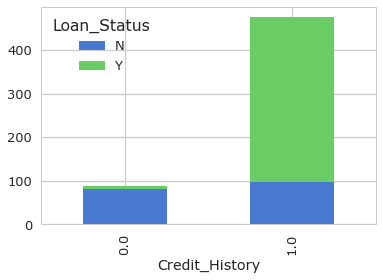

In [61]:
df_cs = pd.crosstab(train_df['Credit_History'],train_df['Loan_Status'])
df_cs.plot(kind='bar',stacked=True)

In [62]:
df_cs

Loan_Status,N,Y
Credit_History,,
0.0000,82,7
1.0000,97,378


### Handling NaN (or NULL) values

In [63]:
train_df.isnull().sum()

Gender                   13
Married                   3
Dependents               15
Education                 0
Self_Employed            32
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount               22
Loan_Amount_Term         14
Credit_History           50
Property_Area             0
Loan_Status               0
TotalIncome               0
ApplicantIncome_Log       0
CoapplicantIncome_Log     0
TotalIncome_Log           0
dtype: int64

In [64]:
test_df.isnull().sum()

Gender                   11
Married                   0
Dependents               10
Education                 0
Self_Employed            23
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount                5
Loan_Amount_Term          6
Credit_History           29
Property_Area             0
TotalIncome               0
ApplicantIncome_Log       0
CoapplicantIncome_Log     0
TotalIncome_Log           0
dtype: int64

### Plan for handling NaN (or NULL) values in the data:

Following table shows the output of the above print(...) line intersperced with comments on how we plan to handle missing data per field.


    Output from print(...)         Strategy to handle missing data
    ----------------------------   -------------------------------------------------  
    Gender               13        impute with mode (i.e. most common) gender
    Married               3        impute with mode (i.e. most common) status
    Dependents           15        see note below (**)
    Education             0    
    Self_Employed        32        impute with mode (i.e. most common) value
    ApplicantIncome       0
    CoapplicantIncome     0
    LoanAmount           22        impute with median() value for loan amount
    Loan_Amount_Term     14        impute with median() value for loan amount
    Credit_History       50        (Yes/No type of field) - use KNN imputation
    Property_Area         0
    Loan_Status           0
    -- we added these fields....
    ApplicantIncome_Log       0
    CoapplicantIncome_Log     0
    Total_Income              0
    Total_Income_Log          0  -- use this field
    dtype: int64

  
  ** NOTE about Dependents field: **
  Dependents have values in [0,1,2,3+], which means that loan processing treats
  3+ dependents same as 3. First we will replace all 3+ with 3, then we will impute
  nulls with most common values (NOTE: this should be treated as a categorical field!)

In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 16 columns):
Gender                   601 non-null object
Married                  611 non-null object
Dependents               599 non-null object
Education                614 non-null object
Self_Employed            582 non-null object
ApplicantIncome          614 non-null int64
CoapplicantIncome        614 non-null float64
LoanAmount               592 non-null float64
Loan_Amount_Term         600 non-null float64
Credit_History           564 non-null float64
Property_Area            614 non-null object
Loan_Status              614 non-null object
TotalIncome              614 non-null float64
ApplicantIncome_Log      614 non-null float64
CoapplicantIncome_Log    614 non-null float64
TotalIncome_Log          614 non-null float64
dtypes: float64(8), int64(1), object(7)
memory usage: 101.5+ KB


In [66]:
# Cetegorical fields
for df in [train_df,test_df]:
    df['Dependents'].replace('3+','3',inplace=True)

for field_name in ['Gender','Married','Dependents','Self_Employed','Credit_History']:
    for df in [train_df, test_df]:
        mode_val = df.loc[df[field_name].notnull(),field_name].mode()[0]
        df[field_name].fillna(mode_val, inplace=True)

In [67]:
# Numeric fields
for field_name in ['Loan_Amount_Term']:
    for df in [train_df, test_df]:
        term_median = df.loc[df[field_name].notnull(),field_name].median()
        df[field_name].fillna(term_median, inplace=True)

In [68]:
# special method for handling LoanAmount
loanAmt_pivot = train_df.pivot_table(index='Self_Employed',columns='Education',
                             values='LoanAmount',aggfunc=np.median)
loanAmt_pivot

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0000,113.0000
Yes,157.5000,130.0000


In [69]:
# Define function to return value of this pivot_table
def lookup(x):
    return loanAmt_pivot.loc[x['Self_Employed'],x['Education']]

# Replace missing LoanAmount values
train_df['LoanAmount'].fillna(train_df[train_df['LoanAmount'].isnull()].apply(lookup, axis=1), inplace=True)
test_df['LoanAmount'].fillna(test_df[test_df['LoanAmount'].isnull()].apply(lookup, axis=1), inplace=True)

In [70]:
train_df['LoanAmount_Log'] = np.log(train_df['LoanAmount'])
test_df['LoanAmount_Log'] = np.log(test_df['LoanAmount'])

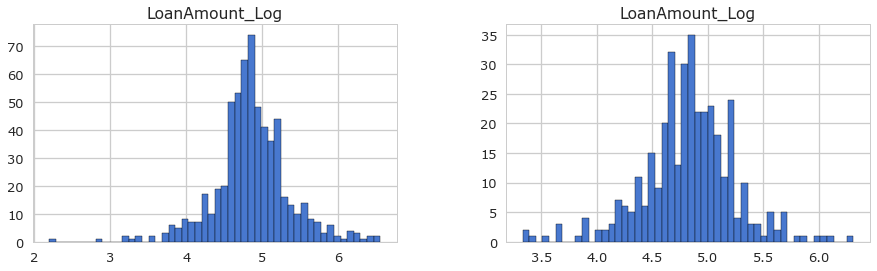

In [71]:
#train_df.hist(column='LoanAmount_Log',bins=50)

f, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,4))
_ = train_df.hist(column='LoanAmount_Log',bins=50, ax=ax[0], edgecolor='k')
_ = test_df.hist(column='LoanAmount_Log',bins=50, ax=ax[1], edgecolor='k')

At this point you should have no `NaN` values in your data. Let's confirm this.

In [72]:
train_df.isnull().sum()

Gender                   0
Married                  0
Dependents               0
Education                0
Self_Employed            0
ApplicantIncome          0
CoapplicantIncome        0
LoanAmount               0
Loan_Amount_Term         0
Credit_History           0
Property_Area            0
Loan_Status              0
TotalIncome              0
ApplicantIncome_Log      0
CoapplicantIncome_Log    0
TotalIncome_Log          0
LoanAmount_Log           0
dtype: int64

In [73]:
test_df.isnull().sum()

Gender                   0
Married                  0
Dependents               0
Education                0
Self_Employed            0
ApplicantIncome          0
CoapplicantIncome        0
LoanAmount               0
Loan_Amount_Term         0
Credit_History           0
Property_Area            0
TotalIncome              0
ApplicantIncome_Log      0
CoapplicantIncome_Log    0
TotalIncome_Log          0
LoanAmount_Log           0
dtype: int64

### Encoding Categorical fields

Plan for encoding categorical fields is as below:

`
Following are the categorical features:
  Gender                 -- (Male/Female): LabelEncode 
  Married                -- (Yes/No): LabelEncode 
  Dependents             -- [0,1,2,3]: OneHotEncode
  Education              -- (Graduate/Not Graduate): LabelEncode 
  Self_Employed          -- (Yes/No): LabelEncode
  ApplicantIncome        -- N/A (numeric)
  CoapplicantIncome      -- N/A (numeric)
  LoanAmount             -- N/A (numeric)
  Loan_Amount_Term       -- N/A (numeric)
  Credit_History         -- Convert to astype(object)
  Property_Area          -- (Semiurban/Urban/Rural): LabelEncode & OneHotEncode 
  Loan_Status            -- (Y/N): LabelEncode 
  ApplicantIncome_Log    -- N/A (numeric)
  CoapplicantIncome_Log  -- N/A (numeric)
  Total_Income           -- N/A (numeric)
  Total_Income_Log       -- N/A (numeric)
  dtype: int64
`

pandas offers a `get_dummies()` function, which does both `LabelEncode()` & `OneHotEncode()` on a column in one step. We will use this utility function to transform columns where `LabelEncode()` & `OneHotEncode()` is recommended.

In [74]:
# first convert the Credit_History column to an object type
train_df['Credit_History'] = train_df['Credit_History'].astype(object)
train_df.loc[(train_df.Credit_History == 1.0),['Credit_History']] = 'Y'
train_df.loc[(train_df.Credit_History == 0.0),['Credit_History']] = 'N'
print(train_df['Credit_History'].value_counts())

# test data
test_df['Credit_History'] = test_df['Credit_History'].astype(object)
test_df.loc[(test_df.Credit_History == 1.0),['Credit_History']] = 'Y'
test_df.loc[(test_df.Credit_History == 0.0),['Credit_History']] = 'N'
print(test_df['Credit_History'].value_counts())

Y    525
N     89
Name: Credit_History, dtype: int64
Y    308
N     59
Name: Credit_History, dtype: int64


In [75]:
# apply LabelEncode() to these columns
from sklearn.preprocessing import LabelEncoder

ccols = ['Gender','Married','Education','Self_Employed', 'Credit_History','Loan_Status']
for col in ccols:
    train_df[col] = LabelEncoder().fit_transform(train_df[col])
    if col != 'Loan_Status':  # test dataset does not have this column!
        test_df[col] = LabelEncoder().fit_transform(test_df[col])

In [76]:
# apply OneHotEncoding (pd.get_dummies()) to these cols
ohe_cols = ['Property_Area']
# for df in [train_df, test_df]:
#     df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)
    
train_df = pd.get_dummies(train_df, columns=ohe_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=ohe_cols, drop_first=True)

In [77]:
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log,LoanAmount_Log,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0000,130.0000,360.0000,1,1,5849.0000,8.6740,0.0000,8.6740,4.8675,0,1
LP001003,1,1,1,0,0,4583,1508.0000,128.0000,360.0000,1,0,6091.0000,8.4301,7.3185,8.7146,4.8520,0,0
LP001005,1,1,0,0,1,3000,0.0000,66.0000,360.0000,1,1,3000.0000,8.0064,0.0000,8.0064,4.1897,0,1
LP001006,1,1,0,1,0,2583,2358.0000,120.0000,360.0000,1,1,4941.0000,7.8567,7.7656,8.5053,4.7875,0,1
LP001008,1,0,0,0,0,6000,0.0000,141.0000,360.0000,1,1,6000.0000,8.6995,0.0000,8.6995,4.9488,0,1


In [78]:
train_df['Dependents'] = train_df['Dependents'].astype(int)
test_df['Dependents'] = test_df['Dependents'].astype(int)

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 18 columns):
Gender                     614 non-null int64
Married                    614 non-null int64
Dependents                 614 non-null int64
Education                  614 non-null int64
Self_Employed              614 non-null int64
ApplicantIncome            614 non-null int64
CoapplicantIncome          614 non-null float64
LoanAmount                 614 non-null float64
Loan_Amount_Term           614 non-null float64
Credit_History             614 non-null int64
Loan_Status                614 non-null int64
TotalIncome                614 non-null float64
ApplicantIncome_Log        614 non-null float64
CoapplicantIncome_Log      614 non-null float64
TotalIncome_Log            614 non-null float64
LoanAmount_Log             614 non-null float64
Property_Area_Semiurban    614 non-null uint8
Property_Area_Urban        614 non-null uint8
dtypes: float64(8), int64(8), uint8(2)
memor

### Save _cleaned_ train & test data to CSV files

In [80]:
clean_train_data_file = './data/loan_prediction_train_data_cleaned.csv'
train_df.to_csv(clean_train_data_file)
print('Saved cleaned training dataset to -> %s' % clean_train_data_file)


clean_test_data_file = './data/loan_prediction_test_data_cleaned.csv'
test_df.to_csv(clean_test_data_file)
print('Saved cleaned test dataset to -> %s' % clean_test_data_file)

Saved cleaned training dataset to -> ./data/loan_prediction_train_data_cleaned.csv
Saved cleaned test dataset to -> ./data/loan_prediction_test_data_cleaned.csv


In [81]:
# just a quick check
train_df2 = pd.read_csv(clean_train_data_file)
train_df2.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log,LoanAmount_Log,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,0,0,0,5849,0.0000,130.0000,360.0000,1,1,5849.0000,8.6740,0.0000,8.6740,4.8675,0,1
1,LP001003,1,1,1,0,0,4583,1508.0000,128.0000,360.0000,1,0,6091.0000,8.4301,7.3185,8.7146,4.8520,0,0
2,LP001005,1,1,0,0,1,3000,0.0000,66.0000,360.0000,1,1,3000.0000,8.0064,0.0000,8.0064,4.1897,0,1
3,LP001006,1,1,0,1,0,2583,2358.0000,120.0000,360.0000,1,1,4941.0000,7.8567,7.7656,8.5053,4.7875,0,1
4,LP001008,1,0,0,0,0,6000,0.0000,141.0000,360.0000,1,1,6000.0000,8.6995,0.0000,8.6995,4.9488,0,1


In [82]:
test_df2 = pd.read_csv(clean_test_data_file)
test_df2.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,ApplicantIncome_Log,CoapplicantIncome_Log,TotalIncome_Log,LoanAmount_Log,Property_Area_Semiurban,Property_Area_Urban
0,LP001015,1,1,0,0,0,5720,0,110.0000,360.0000,1,5720,8.6517,0.0000,8.6517,4.7005,0,1
1,LP001022,1,1,1,0,0,3076,1500,126.0000,360.0000,1,4576,8.0314,7.3132,8.4286,4.8363,0,1
2,LP001031,1,1,2,0,0,5000,1800,208.0000,360.0000,1,6800,8.5172,7.4955,8.8247,5.3375,0,1
3,LP001035,1,1,2,0,0,2340,2546,100.0000,360.0000,1,4886,7.7579,7.8423,8.4941,4.6052,0,1
4,LP001051,1,0,0,1,0,3276,0,78.0000,360.0000,1,3276,8.0944,0.0000,8.0944,4.3567,0,1


**NOTE:** The cleaned up train & test data files have been saved to disk. We can now do the analysis on this cleaned data. Analysis has been done in a separate Notebook.

# <center> -- END -- </center>